In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from scipy.stats import chi2
from tqdm import tqdm  # import tqdm for progress bar
import warnings

from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, approx_fprime
from matplotlib.patches import Ellipse
import matplotlib.patches as patches

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all="ignore")


# ----------------------------------------------------
# 1) TARGET DENSITY (Unnormalized) FOR c CLUSTERS
# ----------------------------------------------------
def target_density_ccluster(x, sigma, centers, m, w, epsilon=1e-8):
    """
    Compute the unnormalized density for a batch of points (M, p) under a c-cluster fuzzy model.

    centers : array of shape (c, p)
    w       : array of shape (c,)  (weights >=0, sum may or may not be 1)
    m       : fuzzy exponent
    sigma   : scale parameter > 0

    density(x) = exp( -1/(sigma^2) * [c * sum_j ( w_j * ||x-c_j||^(-2/(m-1)) ) ]^(m-1) ).
    """
    c = centers.shape[0]  # number of clusters
    M = x.shape[0]

    # dist_power[i, j] = (w_j * ||x_i - c_j||^2)^(-1/(m-1))
    dist_power = np.zeros((M, c))
    for j in range(c):
        dist_j = np.linalg.norm(x - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j ** 2) ** (-1.0 / (m - 1.0))

    # sum across clusters
    sum_dist = np.sum(dist_power, axis=1)  # shape (M,)
    denom = sum_dist
    denom = denom ** (m - 1.0)

    exponent = -1.0 / (sigma**2 * denom + epsilon)
    density = np.exp(exponent)
    return density


# ----------------------------------------------------
# 1B) METROPOLIS–HASTINGS SAMPLER for c CLUSTERS
# ----------------------------------------------------
def metropolis_hastings_ccluster_p(
    target_density, initial_point, sigma, centers, m, w,
    iterations=20000, proposal_std=1.0, burn_in=0.1, seed=42
):
    """
    Metropolis-Hastings sampler to draw from the c-cluster fuzzy density in p-D.
    Returns: samples (N_burned, p), acc_rate
    """
    np.random.seed(seed)

    initial_point = np.asarray(initial_point, dtype=float)
    centers = np.asarray(centers, dtype=float)
    w = np.asarray(w, dtype=float)
    
    p = initial_point.shape[0]
    assert centers.shape[1] == p, \
        f"Dimension mismatch: centers have {centers.shape[1]} features, expected {p}"
    assert w.shape[0] == centers.shape[0], \
        f"w length {w.shape[0]} != number of centers {centers.shape[0]}"



    samples = np.zeros((iterations, p))
    samples[0] = initial_point
    accepted = 0

    # Evaluate density at initial point
    current_val = target_density(samples[0].reshape(1, -1), sigma, centers, m, w)[0]

    for i in range(1, iterations):
        current = samples[i - 1]
        proposal = current + np.random.randn(p) * proposal_std

        proposal_val = target_density(proposal.reshape(1, -1), sigma, centers, m, w)[0]
        alpha = min(1.0, proposal_val / current_val)

        if np.random.rand() < alpha:
            samples[i] = proposal
            current_val = proposal_val
            accepted += 1
        else:
            samples[i] = current

    acceptance_rate = accepted / (iterations - 1)
    burn_in_steps = int(iterations * burn_in)
    return samples[burn_in_steps:], acceptance_rate


# ----------------------------------------------------
# 2) MEMBERSHIP UPDATES (E-step) for c CLUSTERS
# ----------------------------------------------------
def update_membership_c(data, centers, w, m, epsilon=1e-8):
    """
    E-step: Compute fuzzy membership U given current centroids for c clusters.

    U[i,j] = [ (w_j||x_i - c_j||^2)^(-1/(m-1)) ]
             / sum_{k}( (w_j||x_i - c_k||^2)^(-2/(m-1)) )
    """
    N = data.shape[0]
    c = centers.shape[0]

    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0))

    denom = np.sum(dist_power, axis=1, keepdims=True) + epsilon
    U = dist_power / denom
    return U

# ----------------------------------------------------
# 3) CENTROID UPDATES (M-step, part A) for c CLUSTERS
# ----------------------------------------------------
def update_centroids_c(data, U, w, m, epsilon=1e-8):
    """
    Update c centroids in closed form, given membership matrix U and weights w.

    center_j = ( sum_i [  (U[i,j]^m) * x_i ] )
               / sum_i [  (U[i,j]^m) ]
    """
    c = U.shape[1]
    _, dim = data.shape
    centers_new = np.zeros((c, dim))

    for j in range(c):
        u_pow = (U[:, j] ** m)   # shape (N,)
        numerator = np.sum(u_pow[:, None] * data, axis=0)
        denominator = np.sum(u_pow) + epsilon
        centers_new[j] = numerator / denominator

    return centers_new


# ----------------------------------------------------
# 4) PARTIAL NLL WHEN MEMBERSHIP (U) IS FIXED (c CLUSTERS)
# ----------------------------------------------------
def partial_negative_log_likelihood_c_p(
    params, data, U, proposal_samples, proposal_weights, m, c, epsilon=1e-8
):
    """
    Compute partial negative log-likelihood (NLL) for p-dimensional C-cluster model
    with fixed membership matrix U.

    Parameters
    ----------
    params : array-like
        Flattened parameter vector: [sigma, center_1_coords..., center_c_coords..., w_1, ..., w_c]
        where each center has p coordinates.
    data : ndarray, shape (N, p)
        Observed data points in p dimensions.
    U : ndarray
        Fixed membership matrix (N x c) — not used for updates here, but kept for compatibility.
    proposal_samples : ndarray, shape (M, p)
        Samples from the proposal distribution for importance sampling.
    proposal_weights : ndarray, shape (M,)
        Weights of the proposal samples (density under proposal).
    m : float
        Fuzziness parameter (>1).
    c : int
        Number of clusters.
    epsilon : float
        Small constant to prevent division by zero.

    Returns
    -------
    NLL : float
        The partial negative log-likelihood.
    """
    params = np.array(params, dtype=float)
    sigma = params[0]
    p = data.shape[1]

    # Next c*2 entries are the cluster centers
    center_vals = params[1 : 1 + p*c]
    centers = center_vals.reshape((c, p))

    # Next c entries are the weights
    w = params[1 + p*c : 1 + (p+1)*c]

    # (1) "Energy" term over data
    N = data.shape[0]
    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0))

    denom_data = (np.sum(dist_power, axis=1) + epsilon) ** (m - 1.0)
    energy = np.sum(1.0 / (sigma**2 * denom_data + epsilon))

    # (2) Approx normalizing constant via importance sampling
    f_x = target_density_ccluster(proposal_samples, sigma, centers, m, w, epsilon=epsilon)
    ratio = f_x / (proposal_weights + epsilon)
    Z_est = np.mean(ratio) + epsilon

    NLL = N * np.log(Z_est) + energy
    return NLL


# ----------------------------------------------------
# 5) EM-LIKE FUZZY CLUSTERING for c CLUSTERS
# ----------------------------------------------------
def em_like_fuzzy_clustering_c_p(
    data,
    proposal_samples,
    proposal_weights,
    m,
    c,
    initial_sigma=1.0,
    initial_centers=None,
    initial_w=None,
    max_iter=30,
    tol=1e-5,
    random_state=42
):
    """
    EM-like fuzzy clustering approach for c clusters in 2D:
      - E-step: update membership U
      - M-step(A): closed-form centroid update
      - M-step(B): optimize sigma, w (holding U fixed)
      - repeat until convergence
    """
    rng = np.random.RandomState(random_state)
    N, p = data.shape

    sigma = initial_sigma

    # Initialize centers
    if initial_centers is None:
        idx = rng.choice(N, c, replace=False)
        centers = data[idx].copy()
    else:
        centers = np.asarray(initial_centers).reshape((c, p))

    # Initialize weights
    if initial_w is None:
        w = np.ones(c) / c
    else:
        w = np.asarray(initial_w, dtype=float)
        w = w / (w.sum() + 1e-12)

    old_nll = np.inf

    for iteration in range(max_iter):
        # E-step: membership
        U = update_membership_c(data, centers, w, m)
        #U_adj = update_membership_c_adj(data, centers, w, m)
        # M-step(A): centroid update
        centers = update_centroids_c(data, U, w, m)

        # M-step(B): refine sigma, w (keep U fixed)
        #x0 = [sigma] + list(centers.flatten()) + list(w)
        x0 = np.concatenate([[sigma], centers.flatten(), w])


        # Bounds: sigma>0, centers unbounded, w in [0,1]
        bnds = [(1e-5, 100.0)]  # sigma
        bnds += [(None, None)] * (c * p)  # centers
        bnds += [(0.0, 1.0)] * c          # weights
        # for _ in range(c * p):
        #     bnds.append((None, None))  # center coords
        # for _ in range(c):
        #     bnds.append((0.0, 1.0))     # weights

        def objective(params):
            return partial_negative_log_likelihood_c_p(
                params, data, U, proposal_samples, proposal_weights, m, c
            )

        res = minimize(objective, x0, method="L-BFGS-B", bounds=bnds)
        if res.success:
            p_opt = np.array(res.x, dtype=float)
            sigma_opt = p_opt[0]
            cvals_opt = p_opt[1 : 1 + p*c]
            centers_opt = cvals_opt.reshape((c, p))
            w_opt = p_opt[1 + p*c : 1 + (p+1)*c]
            w_opt = w_opt / (w_opt.sum() + 1e-12)

            sigma, centers, w = sigma_opt, centers_opt, w_opt

        # Check convergence
        new_nll = partial_negative_log_likelihood_c_p(
            #[sigma] + list(centers.flatten()) + list(w),
            np.concatenate([[sigma], centers.flatten(), w]),
            data, U, proposal_samples, proposal_weights, m, c
        )
        improvement = abs(old_nll - new_nll)
        print(f"Iteration {iteration+1}/{max_iter}  NLL={new_nll:.6f}  Δ={improvement:.2e}")

        if improvement < tol:
            break
        old_nll = new_nll

    return {
        "c": c,
        "m": m,
        "sigma": sigma,
        "centers": centers,
        "w": w,
        "U": U,
        "NLL": old_nll
        #"U_adj": U_adj
    }


# ----------------------------------------------------
# 6) GMM PROPOSAL FOR IMPORTANCE SAMPLING
# ----------------------------------------------------
def generate_proposal_samples_gmm_c(data, num_samples=5000, n_components=2, random_state=42):
    """
    Fit a GMM to 'data' (with n_components Gaussians) and generate samples for importance sampling.
    Return:
      samples_IS : (num_samples, p)
      proposal_pdf : (num_samples,) = q(x)
    """
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gmm.fit(data)
    samples_IS, _ = gmm.sample(num_samples)
    proposal_pdf = np.exp(gmm.score_samples(samples_IS))
    return samples_IS, proposal_pdf, gmm


# ----------------------------------------------------
# 7) XIE–BENI INDEX
# ----------------------------------------------------
def xie_beni_index(data, U, centers, m, c, w, epsilon=1e-14):
    """
    Compute the Xie–Beni index for fuzzy clustering.
      XB = [ sum_{i=1}^N sum_{j=1}^c (w_j * U[i,j]^m) * ||x_i - center_j||^2 ]
            / [ N * min_{k != l} (||center_k - center_l||^2) ]

    Smaller XB => better clustering.
    """
    N, p = data.shape
    c = centers.shape[0]
    U_m = U**m

    # (1) Numerator: sum of (w_j * U[i,j]^m * ||x_i - center_j||^2)
    dist_sq = np.zeros((N, c))
    for j in range(c):
        diff = data - centers[j]
        dist_sq[:, j] = np.sum(diff**2, axis=1)  # squared distance

    #numerator = np.sum( w * U_m * dist_sq)
    numerator = np.sum(U_m * dist_sq * w[np.newaxis, :])


    # (2) Denominator: N * min pairwise distance among cluster centers
    min_sq_dist = np.min([
        np.sum((centers[k] - centers[l])**2)
        for k in range(c) for l in range(k+1, c)
    ])

    # min_sq_dist = np.inf
    # for k in range(c):
    #     for l in range(k+1, c):
    #         center_diff = centers[k] - centers[l]
    #         dist_sq_kl = np.sum(center_diff**2)
    #         if dist_sq_kl < min_sq_dist:
    #             min_sq_dist = dist_sq_kl

    if min_sq_dist < epsilon:
        # If two centers are extremely close, XB can blow up
        return np.inf

    denominator = N * min_sq_dist
    xb_val = numerator / denominator
    return xb_val




# ----------------------------------------------------
# HELPER: Insert fixed parameter into full parameter vector
# ----------------------------------------------------
def insert_fixed_param(mle_params, param_idx, fixed_value, rest_params):
    new_params = []
    r = 0
    for i in range(len(mle_params)):
        if i == param_idx:
            new_params.append(fixed_value)
        else:
            new_params.append(rest_params[r])
            r += 1
    return np.array(new_params, dtype=float)




# ----------------------------------------------------
# 8) GENERIC PROFILE LIKELIHOOD FUNCTION FOR ONE PARAMETER
# ----------------------------------------------------
def profile_likelihood_param(mle_params, param_idx, data, proposal_samples, proposal_weights, m, c,
                             grid_points=50, range_factor=0.2, alpha=0.05):
    """
    Profile the negative log-likelihood for one parameter (indexed by param_idx)
    in the full parameter vector [σ, centers, weights].

    Returns:
      grid: candidate values for this parameter.
      profile_nll: corresponding partial NLL values.
      threshold: threshold Δ for one degree of freedom.
    """
    N, p = data.shape

    # Extract the MLE value for the parameter we wish to profile.
    p0 = mle_params[param_idx]
    grid = np.linspace(p0 * (1 - range_factor), p0 * (1 + range_factor), grid_points)
    profile_nll = []
    # For one parameter, threshold is based on df=1.
    threshold = 0.5 * chi2.ppf(1 - alpha, df=1)

    # Prepare full bounds for the full parameter vector.
    # Order: index 0: sigma, indices 1..1+2c-1: centers, indices 1+2c..1+3c-1: weights.
    full_bounds = []
    full_bounds.append((1e-5, 100.0))  # sigma
    for i in range(p*c):
        full_bounds.append((None, None))
    for i in range(c):
        full_bounds.append((0.0, 1.0))
    # Prepare bounds for the free parameters (all except the one to be profiled)
    rest_bounds = [full_bounds[i] for i in range(len(full_bounds)) if i != param_idx]

    # The initial guess for the "rest" of the parameters is taken from mle_params.
    rest_initial = np.delete(mle_params, param_idx)

    # Loop over candidate values using tqdm for progress.
    for candidate_val in tqdm(grid, desc=f"Profiling parameter index {param_idx}"):

        # Define an objective function over free parameters.
        def objective_rest(rest_params):
            candidate = insert_fixed_param(mle_params, param_idx, candidate_val, rest_params)
            centers_candidate = candidate[1:1+p*c].reshape((c,p))
            weights_candidate = candidate[1+p*c:1+(p+1)*c]
            U_candidate = update_membership_c(data, centers_candidate, weights_candidate, m)
            return partial_negative_log_likelihood_c_p(candidate, data, U_candidate, proposal_samples, proposal_weights, m, c)

        res = minimize(objective_rest, rest_initial, bounds=rest_bounds, method="L-BFGS-B")
        if res.success:
            candidate_params = insert_fixed_param(mle_params, param_idx, candidate_val, res.x)
            centers_candidate = candidate_params[1:1+p*c].reshape((c,p))
            weights_candidate = candidate_params[1+p*c:1+(1+p)*c]
            U_candidate = update_membership_c(data, centers_candidate, weights_candidate, m)
            nll_val = partial_negative_log_likelihood_c_p(candidate_params, data, U_candidate, proposal_samples, proposal_weights, m, c)
            profile_nll.append(nll_val)
        else:
            profile_nll.append(np.nan)

    profile_nll = np.array(profile_nll)
    return grid, profile_nll, threshold


# ==============================================================================
# 9) NUMERICAL HESSIAN (FINITE DIFFERENCES)
# ==============================================================================
def numerical_hessian(func, x0, epsilon=1e-5):
    x0 = np.array(x0, dtype=float)
    p = x0.shape[0]
    def fwrap(x):
        return func(x)
    grad0 = approx_fprime(x0, fwrap, epsilon)
    hess = np.zeros((p, p), dtype=float)
    for i in range(p):
        x_perturb = x0.copy()
        x_perturb[i] += epsilon
        grad_i = approx_fprime(x_perturb, fwrap, epsilon)
        hess[:, i] = (grad_i - grad0) / epsilon
    return grad0, hess


In [5]:
# ==========================================================
# Classic FCM vs Weighted FCM (under cluster imbalance)
# ==========================================================
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity

np.random.seed(123)

# ==========================================================
# 1. Generate synthetic data (Cluster imbalance)
# ==========================================================
n1 = 5000  # large cluster
mean1 = [2, 2]
cluster1 = np.random.normal(loc=mean1, scale=1, size=(n1, 2))

n2 = 250  # small cluster
mean2 = [7, 7]
cluster2 = np.random.normal(loc=mean2, scale=1, size=(n2, 2))

# Combine
data = np.vstack((cluster1, cluster2))
x, y = data[:, 0], data[:, 1]
n = data.shape[0]

# ==========================================================
# 2. Classic FCM
# ==========================================================
cntr_fcm, u_fcm, _, _, _, _, fpc_fcm = fuzz.cluster.cmeans(
    data.T, c=2, m=2, error=1e-6, maxiter=1000, init=None
)

print("Classic FCM centers:\n", cntr_fcm)
print("Fuzzy Partition Coefficient (FPC):", fpc_fcm)

# ==========================================================
# 3. Weighted FCM (density-based weights)
# ==========================================================
# Estimate local density (inverse weight for dense regions)
kde = KernelDensity(bandwidth=1.0).fit(data)
dens = np.exp(kde.score_samples(data))
weights = 1 / (dens + 1e-6)
weights /= np.mean(weights)  # normalize weights ~1

# Implement WFCM manually
def weighted_fcm(data, c=2, m=2, weights=None, max_iter=100, tol=1e-5):
    n, p = data.shape
    # Initialize cluster centers randomly
    idx = np.random.choice(n, c, replace=False)
    centers = data[idx]

    for it in range(max_iter):
        # Update memberships
        dist = np.zeros((c, n))
        for j in range(c):
            dist[j] = np.linalg.norm(data - centers[j], axis=1)
        dist = np.fmax(dist, 1e-10)  # avoid division by zero

        inv_dist = dist ** (-2 / (m - 1))
        u = inv_dist / np.sum(inv_dist, axis=0)

        # Update centers (weighted)
        centers_new = np.zeros_like(centers)
        for j in range(c):
            w_u_m = weights * (u[j] ** m)
            centers_new[j] = np.sum(w_u_m[:, None] * data, axis=0) / np.sum(w_u_m)

        if np.linalg.norm(centers_new - centers) < tol:
            break
        centers = centers_new

    return centers, u

cntr_wfcm, u_wfcm = weighted_fcm(data, c=2, m=2, weights=weights)
print("Weighted FCM centers:\n", cntr_wfcm)



Classic FCM centers:
 [[1.74402695 1.75538097]
 [3.36118915 3.28087955]]
Fuzzy Partition Coefficient (FPC): 0.7118780360332828
Weighted FCM centers:
 [[1.97490823 1.97683856]
 [7.18116381 7.0786036 ]]


# Figure 1

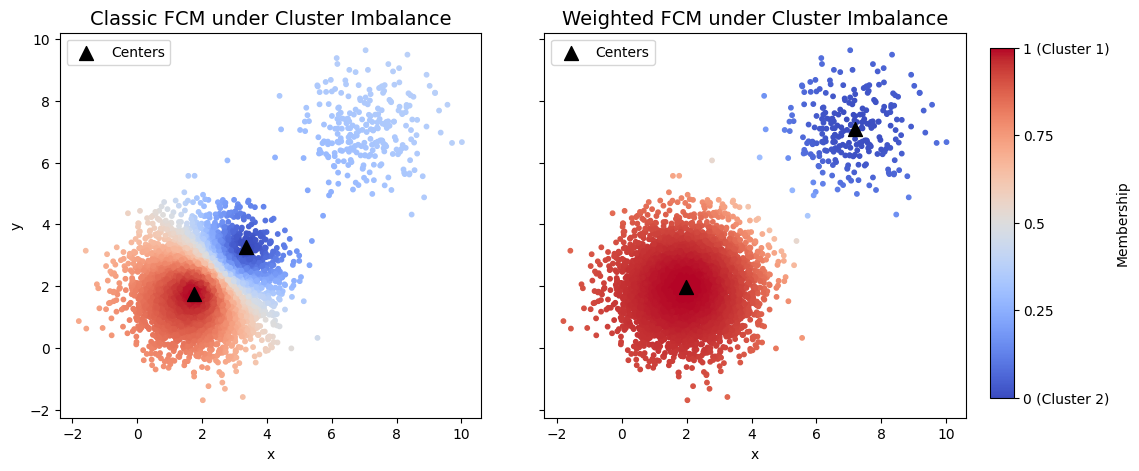

In [7]:
# ==========================================================
# Side-by-side comparison: Classic FCM vs Weighted FCM
# ==========================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# --- (A) Classic FCM membership ---
sc1 = axes[0].scatter(
    membership_df["x"], membership_df["y"],
    c=membership_df["u_classic"],
    cmap="coolwarm", s=10, vmin=0, vmax=1
)
axes[0].scatter(cntr_fcm[:, 0], cntr_fcm[:, 1],
                c="black", s=100, marker="^", label="Centers")
axes[0].set_title("Classic FCM under Cluster Imbalance",
                  fontsize=14)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].legend()

# --- (B) Weighted FCM membership ---
sc2 = axes[1].scatter(
    membership_df["x"], membership_df["y"],
    c=membership_df["u_weighted"],
    cmap="coolwarm", s=10, vmin=0, vmax=1
)
axes[1].scatter(cntr_wfcm[:, 0], cntr_wfcm[:, 1],
                c="black", s=100, marker="^", label="Centers")
axes[1].set_title("Weighted FCM under Cluster Imbalance",
                  fontsize=14)
axes[1].set_xlabel("x")
axes[1].legend()

# Adjust layout before adding colorbar
fig.subplots_adjust(right=0.88, wspace=0.15)

# Shared colorbar positioned neatly to the right
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc2, cax=cbar_ax)
cbar.set_label("Membership")
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(["0 (Cluster 2)", "0.25", "0.5", "0.75", "1 (Cluster 1)"])

plt.show()


# Figure 2

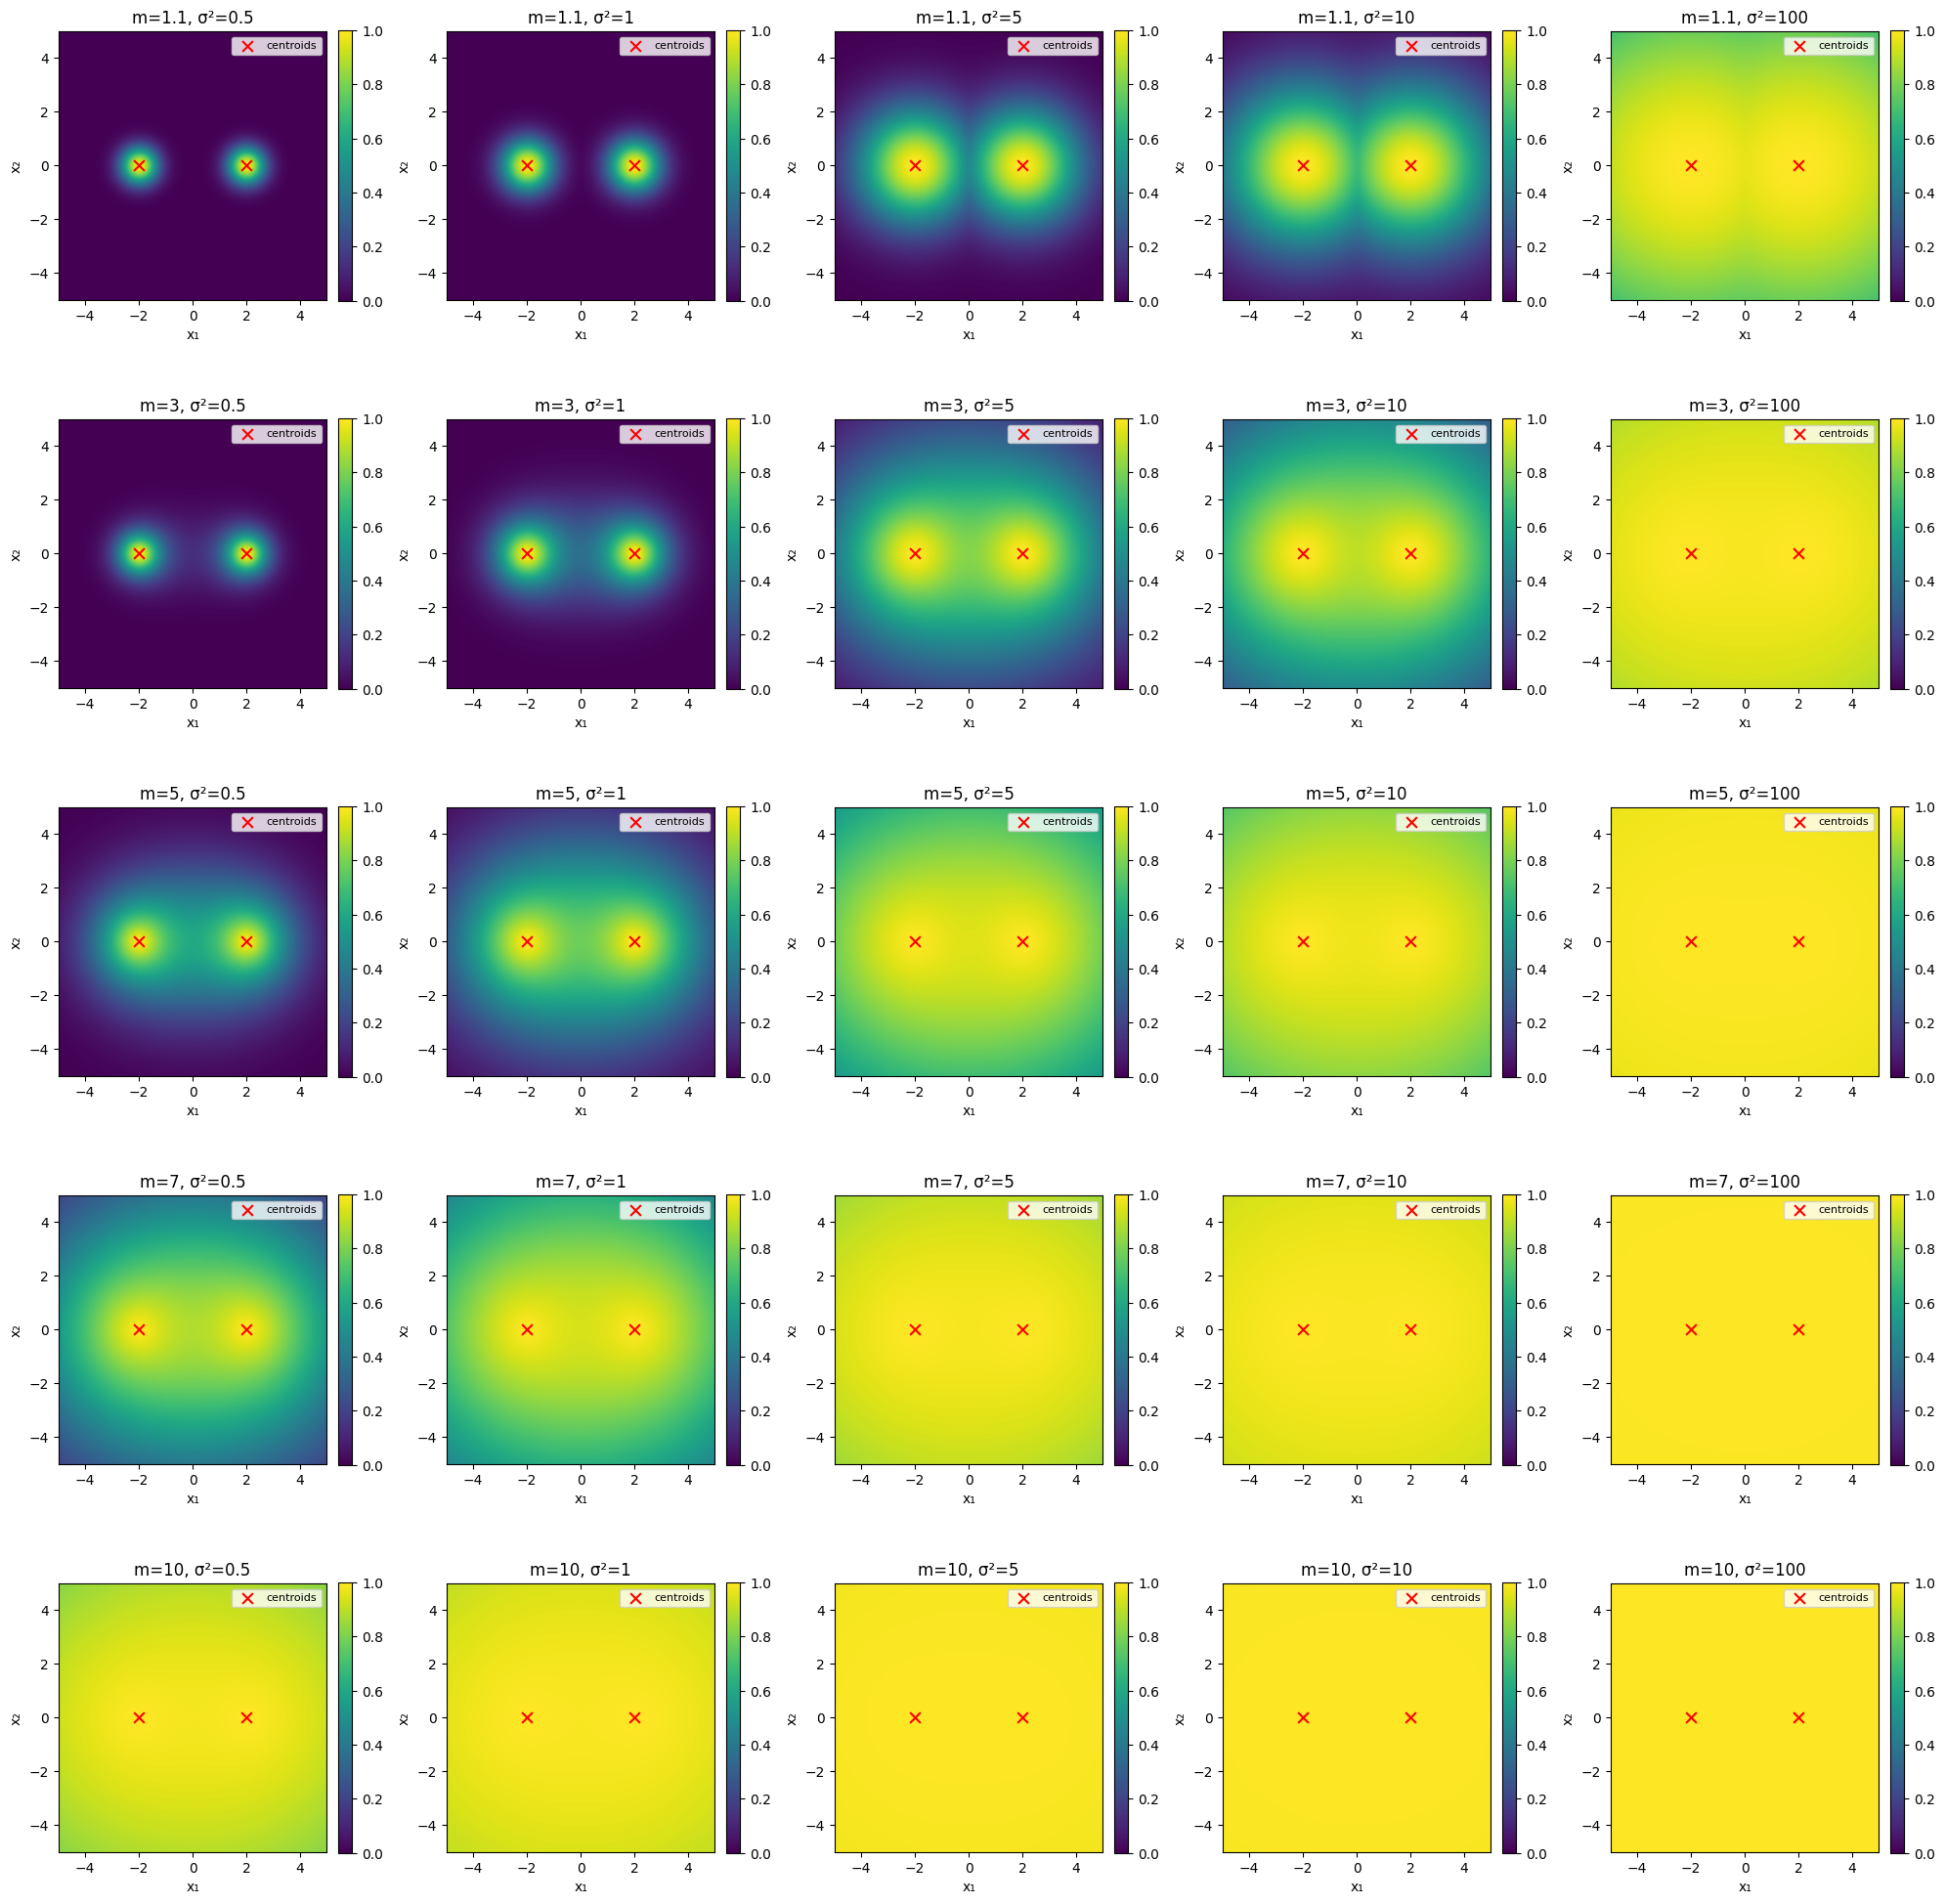

In [8]:
# Define the FCM-induced density (unnormalized)
def fcm_density(x1, x2, V, m, sigma2):
    """
    x1, x2: meshgrid coordinates
    V: list of centroids [(v1x, v1y), (v2x, v2y), ...]
    m: fuzziness parameter (>1)
    sigma2: variance parameter (>0)
    """
    # Compute distance contributions
    d_sum = np.zeros_like(x1)
    for vx, vy in V:
        dist = np.sqrt((x1 - vx)**2 + (x2 - vy)**2)
        dist = np.maximum(dist, 1e-6)  # avoid division by zero
        d_sum += dist ** (-2 / (m - 1))
    
    exponent = -1 / (sigma2 * (d_sum ** (m - 1)))
    return np.exp(exponent)  # ignoring normalization constant

# Set up grid
x = np.linspace(-5, 5, 300)
y = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(x, y)

# Define cluster centroids
V = [(-2, 0), (2, 0)]


# Parameters to explore
m_values = [1.1, 3, 5, 7, 10]
sigma2_values = [0.5, 1, 5, 10, 100]

fig, axes = plt.subplots(len(m_values), len(sigma2_values), figsize=(20, 20))
for i, m in enumerate(m_values):
    for j, sigma2 in enumerate(sigma2_values):
        Z = fcm_density(X, Y, V, m, sigma2)
        ax = axes[i, j]
        im = ax.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='viridis', vmin=0, vmax=1)
        ax.set_title(f"m={m}, σ²={sigma2}")
        ax.scatter(*zip(*V), c='red', marker='x', s=60, label='centroids')
        ax.legend(loc='upper right', fontsize=8)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_xlabel("x₁")
        ax.set_ylabel("x₂")

plt.tight_layout()
plt.show()
